# Qari'

## What is it?
Qar'i is a proof-of-concept, artificially-intelligent solution designed to recognize hand-written Arabic characters.

## Who is the intended stakeholder? 
The intended stakeholder is a defense, security, or justice (DS&J) professional who is not able to read Arabic or one who needs to triage a large set of documents in a short amount of time; however, this proof-of-concept could be extended to any professional who cannot read Arabic or is not able to read Arabic proficiently. 

## Why would this solution be used?
I propose two use cases for this project. 

First, this solution would be used to augment a business unit who is unable to staff sufficient numbers of Arabic linguists; in such an instance, this tool would ideally enable a team to identify documents that have suspicious or derogatory information. A team would then be able to refer these documents to trained linguists as a priority for translation.

Second, a unit that has trained linguists may receive a sufficiently-high volume of handwritten documents that they are unable to translate the documents in an time-efficient manner or without undue fatigue. In this sense, it is important that have some means of prioritizing which documents to complete a full translation on versus which to delay.

Regardless, the purpose of this project is to save a team seconds or minutes in a field where time is often of the essence.

## How is this solution's machine-learning model generated?
This solution utilizes convolutional neural networks as an image classification algorithm meaning that, with initially labeled training data, the algorithm allows the computer to adapt the filters by itself to achieve a result.

In [1]:
import os, shutil
import tensorflow
import keras
# establish location for training
# citing Peter Mortensen's StackOverflow answer at the following URL:
# https://stackoverflow.com/questions/37400974/error-unicode-error-unicodeescape-codec-cant-decode-bytes-in-position-2-3
#data_training_dir = r'Train Images 10080x32x32\train'
data_training_dir = r'Training Images'
#establish location for validation images
#data_validation_dir = r'Validation Images 3360x32x32\validation'
#establish location for testing
data_testing_dir = r'Test Images'

#only select PNG files as images
imgs_train = [file for file in os.listdir(data_training_dir) if file.endswith(r'.png')]
#imgs_val = [file for file in os.listdir(data_validation_dir) if file.endswith(r'.png')]
imgs_test = [file for file in os.listdir(data_testing_dir) if file.endswith(r'.png')]

In [2]:
#imported as basic performance visualization
import matplotlib.pyplot as plt

#importing ImageDataGenerator to "see" the images
from tensorflow.keras import preprocessing

### Reshaping or Standardization of Image Sizes
Typically, it would be necessary to standardize the size of the inputs; however, the creator of the dataset kindly did this for us. Similarly, they labeled the images.

Therefore, the majority of the effort in this section was making sure that we set a decent batch size so as to account for different handwriting size, character inclination, etc.

In [3]:
#cite Keras documentation: https://keras.io/api/preprocessing/image/
#random seed set to improve reproducibility of model

#images were manually sorted into folder in lieu of manipulation via Python scripts
TrainData = tensorflow.keras.preprocessing.image_dataset_from_directory(
    data_training_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    batch_size=336,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)


ValData = tensorflow.keras.preprocessing.image_dataset_from_directory(
    data_training_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    batch_size=84,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)
#including random seed for reproducibility
TestData = tensorflow.keras.preprocessing.image_dataset_from_directory(
    data_testing_dir,
    labels="inferred",
    label_mode='categorical',
    class_names=None,
    batch_size=105,
    shuffle=True,
    seed=123,
)

Found 13440 files belonging to 28 classes.
Using 10752 files for training.
Found 13440 files belonging to 28 classes.
Using 2688 files for validation.
Found 3360 files belonging to 28 classes.


In [4]:
print(len(TrainData))
print(len(ValData))
print(len(TestData))

32
32
32


## Model
The model being created is a convolutional neural network that should essentially mimic an animal's acquisition of data about their surroundings by sight, or the human ability to read. A callback has been included so that the model is interrupted when validation loss begins to increase, so as to limit the amount of overfitting present in the model.

In [5]:
#import keras layers & models to generate CNN
from keras import layers
from keras import models

#import optimizers from keras after layers
from keras import optimizers

#cite Geeks for Geeks article:
#https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
#import keras callbacks to implement early stopping
from keras import callbacks

earlystopping = callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    patience = 5,
    restore_best_weights = True
)


#models.sequential selected because we are inputting and outputting data
#cite: https://towardsdatascience.com/sequence-models-and-recurrent-neural-networks-rnns-62cadeb4f1e1#:~:text=Sequence%20models%20are%20the%20machine,algorithm%20used%20in%20sequence%20models.
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(28, activation='sigmoid'))


#Cite Sanket Doshi's explanation of ADAM optimization at following URL:
#https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6#:~:text=Gradient%20Descent%20is%20the%20most,linear%20regression%20and%20classification%20algorithms.
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['acc', keras.metrics.TruePositives(), keras.metrics.Precision(), keras.metrics.Recall()]
             )


C:\Users\rogolden\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Training the Model
This model is trained using the Training dataset that we pulled from the directory. The model performance is then validated using the Validation dataset that was set aside using the dataset_from_directory command.

In [6]:
#train model
history = model.fit(
    TrainData, 
    validation_data=(ValData), 
    epochs=50,  
    callbacks = [earlystopping])

Epoch 1/50
32/32 [==============================] - 523s 16s/step - loss: 7.8968 - acc: 0.1662 - true_positives: 9298.0000 - precision: 0.0417 - recall: 0.8648 - val_loss: 1.8980 - val_acc: 0.4498 - val_true_positives: 2649.0000 - val_precision: 0.0484 - val_recall: 0.9855
Epoch 2/50
32/32 [==============================] - 579s 18s/step - loss: 1.3010 - acc: 0.6021 - true_positives: 10678.0000 - precision: 0.0498 - recall: 0.9931 - val_loss: 1.1172 - val_acc: 0.6730 - val_true_positives: 2673.0000 - val_precision: 0.0507 - val_recall: 0.9944
Epoch 3/50
32/32 [==============================] - 602s 19s/step - loss: 0.6273 - acc: 0.7960 - true_positives: 10746.0000 - precision: 0.0516 - recall: 0.9994 - val_loss: 0.9450 - val_acc: 0.7232 - val_true_positives: 2677.0000 - val_precision: 0.0512 - val_recall: 0.9959
Epoch 4/50
32/32 [==============================] - 596s 18s/step - loss: 0.3207 - acc: 0.8573 - true_positives: 10751.0000 - precision: 0.0519 - recall: 0.9999 - val_loss: 1.0

In [7]:
test_loss, test_accuracy, test_TruePos, test_precision, test_recall = model.evaluate(TestData)

32/32 [==============================] - 41s 1s/step - loss: 0.8354 - acc: 0.7318 - true_positives: 3351.0000 - precision: 0.0514 - recall: 0.9973


## Saving the Model
Several models were generated during this development. Due to size constraints, they cannot be uploaded to the GitHub repository (>25 MB). Additionally, for simplicity, this solution will provide the source code for the models deemed successful.


In [8]:
#model.save('Qar_model_30epochs.h5')
model.save('Qar_model_8epochs.h5')

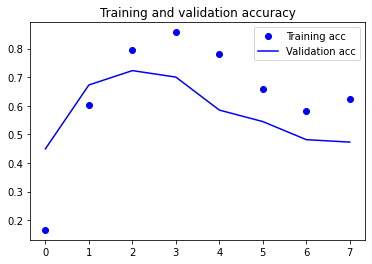

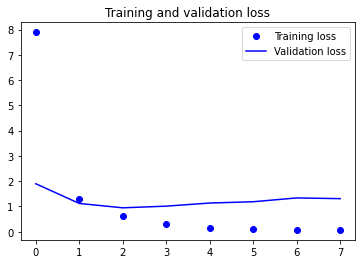

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


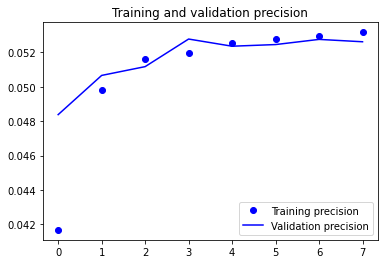

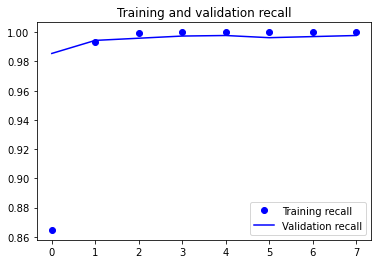

In [17]:
%matplotlib inline

prec = history.history['precision']
val_prec = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
epochs = range(len(acc))
plt.plot(epochs, prec, 'bo', label='Training precision')
plt.plot(epochs, val_prec, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()
plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

## Overall Evaluation
Overall, this model has flaws that need to be rectified.
The accuracy of the model leaves much to be desired, and would hinder the analyst more than aid them due to the inability to 